# DL - HM02.3

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Hyperparameters

In [2]:
class Hyperparameters:
    INPUT_SIZE = 784
    ENC1_SIZE = 256     # Rough Layer
    ENC2_SIZE = 128
    BOTTLENECK_SIZE = 64
    DEC2_SIZE = 128
    DEC1_SIZE = 256
    MLP_HIDDEN_SIZE = 128
    OUTPUT_SIZE = 10
    
    LEARNING_RATE_PAIR1 = 0.001 
    NUM_EPOCHS_PAIR1 = 15
    
    LEARNING_RATE_PAIR2 = 0.001
    NUM_EPOCHS_PAIR2 = 100
    
    LEARNING_RATE_PAIR3 = 0.001
    NUM_EPOCHS_PAIR3 = 100
    
    LEARNING_RATE_MLP = 0.001
    NUM_EPOCHS_MLP = 500
    
    NOISE_FACTOR = 0.5
    LEAKY_RELU_ALPHA = 0.01
    
    TRAIN_RATIO = 0.70
    VAL_RATIO = 0.10
    TEST_RATIO = 0.20
    
    ACT_ENC1 = "sigmoid"      # Rough Layer
    ACT_ENC2 = "leaky_relu"
    ACT_ENC3 = "leaky_relu"
    ACT_DEC1 = "leaky_relu"
    ACT_DEC2 = "leaky_relu"
    ACT_DEC3 = "sigmoid"
    ACT_MLP1 = "leaky_relu"
    ACT_MLP2 = "softmax"      # تغییر به سافت‌مکس

In [3]:
HP = Hyperparameters()

## Functions

In [4]:
# def sigmoid_activation(x):
#     return 1 / (1 + np.exp(-x))

def sigmoid_activation(x):
    # نسخه پایدارتر برای جلوگیری از سرریز
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid_activation(x)
    return sig * (1 - sig)

def relu_activation(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def leaky_relu_activation(x, alpha=HP.LEAKY_RELU_ALPHA):
    x = np.clip(x, -100, 100)  # clipping to prevent overflow
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=HP.LEAKY_RELU_ALPHA):
    x = np.clip(x, -100, 100)  # clipping to prevent overflow
    return np.where(x > 0, 1, alpha)

def purelin_activation(x):
    return x

def purelin_derivative(x):
    return np.ones_like(x)

def softmax_activation(x):
    exp_x = np.exp(x - np.max(x))  # برای پایداری عددی
    return exp_x / np.sum(exp_x)

def softmax_derivative(x):
    # مشتق سافت‌مکس به صورت دقیق برای backpropagation
    s = softmax_activation(x)
    return s * (1 - s)  # تقریبی ساده برای محاسبات

In [5]:
def get_activation(x, activation_name):
    if activation_name == "relu":
        return relu_activation(x)

    elif activation_name == "leaky_relu":
        return leaky_relu_activation(x)
        
    elif activation_name == "sigmoid":
        return sigmoid_activation(x)
        
    elif activation_name == "purelin":
        return purelin_activation(x)
    
    elif activation_name == "softmax":
        return softmax_activation(x)
    
    else:
        raise ValueError(f"Unknown activation: {activation_name}")

In [6]:
def get_derivative(x, activation_name):
    if activation_name == "relu":
        return relu_derivative(x)

    elif activation_name == "leaky_relu":
        return leaky_relu_derivative(x)
        
    elif activation_name == "sigmoid":
        return sigmoid_derivative(x)
        
    elif activation_name == "purelin":
        return purelin_derivative(x)
    
    elif activation_name == "softmax":
        return softmax_derivative(x)
    
    else:
        raise ValueError(f"Unknown derivative: {activation_name}")

## Fetch data

In [7]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X_raw, y_labels = mnist["data"], mnist["target"].astype(np.int32)

## Normalize

In [8]:
X_raw = X_raw / 255.0

## One-Hot encoding

In [9]:
y_one_hot = np.zeros((y_labels.shape[0], HP.OUTPUT_SIZE))
for i, label in enumerate(y_labels):
    y_one_hot[i, label] = 1

## Train/Test split

In [10]:
total_samples = X_raw.shape[0]
num_train = int(total_samples * HP.TRAIN_RATIO)
num_val = int(total_samples * HP.VAL_RATIO)
num_test = total_samples - num_train - num_val

## Shuflling

In [11]:
indices = np.random.permutation(total_samples)
X_shuffled = X_raw[indices]
y_shuffled = y_one_hot[indices]
y_labels_shuffled = y_labels[indices]

## Pure data

In [12]:
X_train_clean = X_shuffled[:num_train]
y_train = y_shuffled[:num_train]
y_train_labels = y_labels_shuffled[:num_train]
X_val_clean = X_shuffled[num_train:num_train+num_val]
y_val = y_shuffled[num_train:num_train+num_val]
y_val_labels = y_labels_shuffled[num_train:num_train+num_val]
X_test_clean = X_shuffled[num_train+num_val:]
y_test = y_shuffled[num_train+num_val:]
y_test_labels = y_labels_shuffled[num_train+num_val:]

## Add Noise

In [13]:
X_train_noisy = X_train_clean + HP.NOISE_FACTOR * np.random.normal(loc=0.0, scale=1.0, size=X_train_clean.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_val_noisy = X_val_clean + HP.NOISE_FACTOR * np.random.normal(loc=0.0, scale=1.0, size=X_val_clean.shape)
X_val_noisy = np.clip(X_val_noisy, 0., 1.)
X_test_noisy = X_test_clean + HP.NOISE_FACTOR * np.random.normal(loc=0.0, scale=1.0, size=X_test_clean.shape)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

## Initialization wheights

### AutoEncoder

In [14]:
w_enc1_upper = np.random.uniform(-0.5, 0.5, (HP.ENC1_SIZE, HP.INPUT_SIZE))
b_enc1_upper = np.zeros(HP.ENC1_SIZE)
w_enc1_lower = np.random.uniform(-0.5, 0.5, (HP.ENC1_SIZE, HP.INPUT_SIZE))
b_enc1_lower = np.zeros(HP.ENC1_SIZE)
w_dec1 = np.random.uniform(-0.5, 0.5, (HP.INPUT_SIZE, HP.ENC1_SIZE))
b_dec1 = np.zeros(HP.INPUT_SIZE)

w_enc2 = np.random.uniform(-0.5, 0.5, (HP.ENC2_SIZE, HP.ENC1_SIZE))
b_enc2 = np.zeros(HP.ENC2_SIZE)
w_dec2 = np.random.uniform(-0.5, 0.5, (HP.INPUT_SIZE, HP.ENC2_SIZE)) 
b_dec2 = np.zeros(HP.INPUT_SIZE)

w_enc3 = np.random.uniform(-0.5, 0.5, (HP.BOTTLENECK_SIZE, HP.ENC2_SIZE))
b_enc3 = np.zeros(HP.BOTTLENECK_SIZE)
w_dec3 = np.random.uniform(-0.5, 0.5, (HP.INPUT_SIZE, HP.BOTTLENECK_SIZE))
b_dec3 = np.zeros(HP.INPUT_SIZE)

### MLP

In [15]:
w_mlp1 = np.random.uniform(-0.5, 0.5, (HP.MLP_HIDDEN_SIZE, HP.BOTTLENECK_SIZE))
b_mlp1 = np.zeros(HP.MLP_HIDDEN_SIZE)
w_mlp2 = np.random.uniform(-0.5, 0.5, (HP.OUTPUT_SIZE, HP.MLP_HIDDEN_SIZE))
b_mlp2 = np.zeros(HP.OUTPUT_SIZE)

## Trainning

In [16]:
def train_rough_layer(input_data, target, learning_rate):
    global w_enc1_upper, b_enc1_upper, w_enc1_lower, b_enc1_lower, w_dec1, b_dec1
    
    net_enc1_upper = np.dot(w_enc1_upper, input_data) + b_enc1_upper
    out_enc1_upper = get_activation(net_enc1_upper, HP.ACT_ENC1)
    net_enc1_lower = np.dot(w_enc1_lower, input_data) + b_enc1_lower
    out_enc1_lower = get_activation(net_enc1_lower, HP.ACT_ENC1)
    out_enc1 = (out_enc1_upper + out_enc1_lower) / 2.0
    
    net_dec1 = np.dot(w_dec1, out_enc1) + b_dec1
    out_dec1 = get_activation(net_dec1, HP.ACT_DEC3)
    
    error_dec1 = target - out_dec1
    delta_dec1 = error_dec1 * get_derivative(net_dec1, HP.ACT_DEC3)
    delta_enc1 = np.dot(w_dec1.T, delta_dec1) * get_derivative(out_enc1, HP.ACT_ENC1)
    
    delta_enc1_upper = delta_enc1 * 0.5
    delta_enc1_lower = delta_enc1 * 0.5
    
    w_dec1 += learning_rate * np.outer(delta_dec1, out_enc1)
    b_dec1 += learning_rate * delta_dec1
    w_enc1_upper += learning_rate * np.outer(delta_enc1_upper, input_data)
    b_enc1_upper += learning_rate * delta_enc1_upper
    w_enc1_lower += learning_rate * np.outer(delta_enc1_lower, input_data)
    b_enc1_lower += learning_rate * delta_enc1_lower
    
    return out_enc1, out_dec1, np.mean(error_dec1 ** 2)

In [17]:
def train_layer_pair(input_data, target, w_enc, b_enc, w_dec, b_dec, act_enc, act_dec, learning_rate):
    net_enc = np.dot(w_enc, input_data) + b_enc
    out_enc = get_activation(net_enc, act_enc)
    
    net_dec = np.dot(w_dec, out_enc) + b_dec
    out_dec = get_activation(net_dec, act_dec)
    
    error_dec = target - out_dec
    delta_dec = error_dec * get_derivative(net_dec, act_dec)
    delta_enc = np.dot(w_dec.T, delta_dec) * get_derivative(net_enc, act_enc)
    
    w_dec += learning_rate * np.outer(delta_dec, out_enc)
    b_dec += learning_rate * delta_dec
    w_enc += learning_rate * np.outer(delta_enc, input_data)
    b_enc += learning_rate * delta_enc
    
    return out_enc, out_dec, np.mean(error_dec ** 2)

In [18]:
def train_mlp(bottleneck, target, learning_rate):
    global w_mlp1, b_mlp1, w_mlp2, b_mlp2
    
    # Forward pass
    net_mlp1 = np.dot(w_mlp1, bottleneck) + b_mlp1
    out_mlp1 = get_activation(net_mlp1, HP.ACT_MLP1)
    
    net_mlp2 = np.dot(w_mlp2, out_mlp1) + b_mlp2
    out_mlp2 = get_activation(net_mlp2, HP.ACT_MLP2)  # حالا سافت‌مکس است
    
    # محاسبه خطا (cross-entropy loss)
    error_mlp2 = target - out_mlp2  # برای سافت‌مکس، خطا مستقیماً محاسبه می‌شود
    delta_mlp2 = error_mlp2  # مشتق سافت‌مکس با cross-entropy ساده می‌شود
    
    # Backpropagation
    error_mlp1 = np.dot(w_mlp2.T, delta_mlp2)
    delta_mlp1 = error_mlp1 * get_derivative(net_mlp1, HP.ACT_MLP1)
    
    # به‌روزرسانی وزن‌ها و بایاس‌ها
    w_mlp2 += learning_rate * np.outer(delta_mlp2, out_mlp1)
    b_mlp2 += learning_rate * delta_mlp2
    w_mlp1 += learning_rate * np.outer(delta_mlp1, bottleneck)
    b_mlp1 += learning_rate * delta_mlp1
    
    return out_mlp2

In [19]:
def full_feedforward_encoder(input_data):
    net_enc1_upper = np.dot(w_enc1_upper, input_data) + b_enc1_upper
    out_enc1_upper = get_activation(net_enc1_upper, HP.ACT_ENC1)
    net_enc1_lower = np.dot(w_enc1_lower, input_data) + b_enc1_lower
    out_enc1_lower = get_activation(net_enc1_lower, HP.ACT_ENC1)
    out_enc1 = (out_enc1_upper + out_enc1_lower) / 2.0
    
    net_enc2 = np.dot(w_enc2, out_enc1) + b_enc2
    out_enc2 = get_activation(net_enc2, HP.ACT_ENC2)
    
    net_enc3 = np.dot(w_enc3, out_enc2) + b_enc3
    out_enc3 = get_activation(net_enc3, HP.ACT_ENC3)
    
    return out_enc3

### History memory

In [20]:
train_mse_history = {
    "Pair_1": np.zeros(HP.NUM_EPOCHS_PAIR1),
    "Pair_2": np.zeros(HP.NUM_EPOCHS_PAIR2),
    "Pair_3": np.zeros(HP.NUM_EPOCHS_PAIR3)
}
val_mse_history = {
    "Pair_1": np.zeros(HP.NUM_EPOCHS_PAIR1),
    "Pair_2": np.zeros(HP.NUM_EPOCHS_PAIR2),
    "Pair_3": np.zeros(HP.NUM_EPOCHS_PAIR3)
}
train_acc_history = np.zeros(HP.NUM_EPOCHS_MLP)
val_acc_history = np.zeros(HP.NUM_EPOCHS_MLP)

### Autoencoder

In [21]:
weights_history_pair1 = {
    "w_enc1_upper": [],
    "b_enc1_upper": [],
    "w_enc1_lower": [],
    "b_enc1_lower": [],
    "w_dec1": [],
    "b_dec1": [],
    "val_mse": []
}

In [22]:
# Pair 1: ENC1 (Rough) + DEC1
for epoch in range(HP.NUM_EPOCHS_PAIR1):
    train_loss = 0
    val_loss = 0
    for i in range(num_train):
        _, _, mse = train_rough_layer(X_train_noisy[i], X_train_clean[i], HP.LEARNING_RATE_PAIR1)
        train_loss += mse
    for i in range(num_val):
        out_enc1 = (get_activation(np.dot(w_enc1_upper, X_val_noisy[i]) + b_enc1_upper, HP.ACT_ENC1) +
                    get_activation(np.dot(w_enc1_lower, X_val_noisy[i]) + b_enc1_lower, HP.ACT_ENC1)) / 2.0
        out_dec1 = get_activation(np.dot(w_dec1, out_enc1) + b_dec1, HP.ACT_DEC3)
        val_loss += np.mean((X_val_clean[i] - out_dec1) ** 2)
    
    train_mse_history["Pair_1"][epoch] = train_loss / num_train
    val_mse_history["Pair_1"][epoch] = val_loss / num_val
    
    # ذخیره وزن‌ها و خطای اعتبارسنجی
    weights_history_pair1["w_enc1_upper"].append(w_enc1_upper.copy())
    weights_history_pair1["b_enc1_upper"].append(b_enc1_upper.copy())
    weights_history_pair1["w_enc1_lower"].append(w_enc1_lower.copy())
    weights_history_pair1["b_enc1_lower"].append(b_enc1_lower.copy())
    weights_history_pair1["w_dec1"].append(w_dec1.copy())
    weights_history_pair1["b_dec1"].append(b_dec1.copy())
    weights_history_pair1["val_mse"].append(val_mse_history["Pair_1"][epoch])
    
    print(f"Epoch {epoch+1}/{HP.NUM_EPOCHS_PAIR1}, Train MSE: {train_mse_history['Pair_1'][epoch]:.4f}, Val MSE: {val_mse_history['Pair_1'][epoch]:.4f}")

Epoch 1/15, Train MSE: 0.0660, Val MSE: 0.0507
Epoch 2/15, Train MSE: 0.0452, Val MSE: 0.0420
Epoch 3/15, Train MSE: 0.0402, Val MSE: 0.0393
Epoch 4/15, Train MSE: 0.0384, Val MSE: 0.0380
Epoch 5/15, Train MSE: 0.0378, Val MSE: 0.0383
Epoch 6/15, Train MSE: 0.0384, Val MSE: 0.0386
Epoch 7/15, Train MSE: 0.0380, Val MSE: 0.0379
Epoch 8/15, Train MSE: 0.0374, Val MSE: 0.0373
Epoch 9/15, Train MSE: 0.0368, Val MSE: 0.0366
Epoch 10/15, Train MSE: 0.0362, Val MSE: 0.0364
Epoch 11/15, Train MSE: 0.0364, Val MSE: 0.0368
Epoch 12/15, Train MSE: 0.0368, Val MSE: 0.0370
Epoch 13/15, Train MSE: 0.0367, Val MSE: 0.0369
Epoch 14/15, Train MSE: 0.0368, Val MSE: 0.0374
Epoch 15/15, Train MSE: 0.0378, Val MSE: 0.0384


In [23]:
# انتخاب بهترین وزن‌ها بر اساس کمترین خطای اعتبارسنجی
best_epoch = np.argmin(weights_history_pair1["val_mse"])
w_enc1_upper = weights_history_pair1["w_enc1_upper"][best_epoch]
b_enc1_upper = weights_history_pair1["b_enc1_upper"][best_epoch]
w_enc1_lower = weights_history_pair1["w_enc1_lower"][best_epoch]
b_enc1_lower = weights_history_pair1["b_enc1_lower"][best_epoch]
w_dec1 = weights_history_pair1["w_dec1"][best_epoch]
b_dec1 = weights_history_pair1["b_dec1"][best_epoch]
print(f"Best weights for Pair 1 selected from epoch {best_epoch + 1} with Val MSE: {weights_history_pair1['val_mse'][best_epoch]:.4f}")

Best weights for Pair 1 selected from epoch 10 with Val MSE: 0.0364


In [24]:
# محاسبه خروجی‌های Encoder 1 با بهترین وزن‌ها
enc1_outputs_train = np.zeros((num_train, HP.ENC1_SIZE))
enc1_outputs_val = np.zeros((num_val, HP.ENC1_SIZE))
for i in range(num_train):
    enc1_outputs_train[i] = (get_activation(np.dot(w_enc1_upper, X_train_noisy[i]) + b_enc1_upper, HP.ACT_ENC1) +
                            get_activation(np.dot(w_enc1_lower, X_train_noisy[i]) + b_enc1_lower, HP.ACT_ENC1)) / 2.0
for i in range(num_val):
    enc1_outputs_val[i] = (get_activation(np.dot(w_enc1_upper, X_val_noisy[i]) + b_enc1_upper, HP.ACT_ENC1) +
                          get_activation(np.dot(w_enc1_lower, X_val_noisy[i]) + b_enc1_lower, HP.ACT_ENC1)) / 2.0

In [25]:
weights_history_pair2 = {
    "w_enc2": [],
    "b_enc2": [],
    "w_dec2": [],
    "b_dec2": [],
    "val_mse": []
}

In [26]:
# Pair 2: ENC2 + DEC2
for epoch in range(HP.NUM_EPOCHS_PAIR2):
    train_loss = 0
    val_loss = 0
    for i in range(num_train):
        _, _, mse = train_layer_pair(enc1_outputs_train[i], X_train_clean[i], w_enc2, b_enc2, w_dec2, b_dec2, HP.ACT_ENC2, HP.ACT_DEC3, HP.LEARNING_RATE_PAIR2)
        train_loss += mse
    for i in range(num_val):
        out_enc2 = get_activation(np.dot(w_enc2, enc1_outputs_val[i]) + b_enc2, HP.ACT_ENC2)
        out_dec2 = get_activation(np.dot(w_dec2, out_enc2) + b_dec2, HP.ACT_DEC3)
        val_loss += np.mean((X_val_clean[i] - out_dec2) ** 2)
    
    train_mse_history["Pair_2"][epoch] = train_loss / num_train
    val_mse_history["Pair_2"][epoch] = val_loss / num_val
    
    # ذخیره وزن‌ها و خطای اعتبارسنجی
    weights_history_pair2["w_enc2"].append(w_enc2.copy())
    weights_history_pair2["b_enc2"].append(b_enc2.copy())
    weights_history_pair2["w_dec2"].append(w_dec2.copy())
    weights_history_pair2["b_dec2"].append(b_dec2.copy())
    weights_history_pair2["val_mse"].append(val_mse_history["Pair_2"][epoch])
    
    print(f"Epoch {epoch+1}/{HP.NUM_EPOCHS_PAIR2}, Train MSE: {train_mse_history['Pair_2'][epoch]:.4f}, Val MSE: {val_mse_history['Pair_2'][epoch]:.4f}")

Epoch 1/100, Train MSE: 0.0622, Val MSE: 0.0466
Epoch 2/100, Train MSE: 0.0439, Val MSE: 0.0424
Epoch 3/100, Train MSE: 0.0405, Val MSE: 0.0391
Epoch 4/100, Train MSE: 0.0381, Val MSE: 0.0366
Epoch 5/100, Train MSE: 0.0361, Val MSE: 0.0360
Epoch 6/100, Train MSE: 0.0356, Val MSE: 0.0356
Epoch 7/100, Train MSE: 0.0346, Val MSE: 0.0345
Epoch 8/100, Train MSE: 0.0340, Val MSE: 0.0337
Epoch 9/100, Train MSE: 0.0334, Val MSE: 0.0334
Epoch 10/100, Train MSE: 0.0331, Val MSE: 0.0332
Epoch 11/100, Train MSE: 0.0329, Val MSE: 0.0330
Epoch 12/100, Train MSE: 0.0327, Val MSE: 0.0328
Epoch 13/100, Train MSE: 0.0326, Val MSE: 0.0327
Epoch 14/100, Train MSE: 0.0324, Val MSE: 0.0326
Epoch 15/100, Train MSE: 0.0323, Val MSE: 0.0325
Epoch 16/100, Train MSE: 0.0312, Val MSE: 0.0311
Epoch 17/100, Train MSE: 0.0308, Val MSE: 0.0310
Epoch 18/100, Train MSE: 0.0307, Val MSE: 0.0309
Epoch 19/100, Train MSE: 0.0306, Val MSE: 0.0308
Epoch 20/100, Train MSE: 0.0305, Val MSE: 0.0307
Epoch 21/100, Train MSE: 0.03

In [27]:
# انتخاب بهترین وزن‌ها
best_epoch = np.argmin(weights_history_pair2["val_mse"])
w_enc2 = weights_history_pair2["w_enc2"][best_epoch]
b_enc2 = weights_history_pair2["b_enc2"][best_epoch]
w_dec2 = weights_history_pair2["w_dec2"][best_epoch]
b_dec2 = weights_history_pair2["b_dec2"][best_epoch]
print(f"Best weights for Pair 2 selected from epoch {best_epoch + 1} with Val MSE: {weights_history_pair2['val_mse'][best_epoch]:.4f}")

Best weights for Pair 2 selected from epoch 100 with Val MSE: 0.0287


In [28]:
# محاسبه خروجی‌های Encoder 2 با بهترین وزن‌ها
enc2_outputs_train = np.zeros((num_train, HP.ENC2_SIZE))
enc2_outputs_val = np.zeros((num_val, HP.ENC2_SIZE))
for i in range(num_train):
    enc2_outputs_train[i] = get_activation(np.dot(w_enc2, enc1_outputs_train[i]) + b_enc2, HP.ACT_ENC2)
for i in range(num_val):
    enc2_outputs_val[i] = get_activation(np.dot(w_enc2, enc1_outputs_val[i]) + b_enc2, HP.ACT_ENC2)

In [29]:
weights_history_pair3 = {
    "w_enc3": [],
    "b_enc3": [],
    "w_dec3": [],
    "b_dec3": [],
    "val_mse": []
}

In [30]:
# Pair 3: ENC3 + DEC3
for epoch in range(HP.NUM_EPOCHS_PAIR3):
    train_loss = 0
    val_loss = 0
    for i in range(num_train):
        _, _, mse = train_layer_pair(enc2_outputs_train[i], X_train_clean[i], w_enc3, b_enc3, w_dec3, b_dec3, HP.ACT_ENC3, HP.ACT_DEC3, HP.LEARNING_RATE_PAIR3)
        train_loss += mse
    for i in range(num_val):
        out_enc3 = get_activation(np.dot(w_enc3, enc2_outputs_val[i]) + b_enc3, HP.ACT_ENC3)
        out_dec3 = get_activation(np.dot(w_dec3, out_enc3) + b_dec3, HP.ACT_DEC3)
        val_loss += np.mean((X_val_clean[i] - out_dec3) ** 2)
    
    train_mse_history["Pair_3"][epoch] = train_loss / num_train
    val_mse_history["Pair_3"][epoch] = val_loss / num_val
    
    # ذخیره وزن‌ها و خطای اعتبارسنجی
    weights_history_pair3["w_enc3"].append(w_enc3.copy())
    weights_history_pair3["b_enc3"].append(b_enc3.copy())
    weights_history_pair3["w_dec3"].append(w_dec3.copy())
    weights_history_pair3["b_dec3"].append(b_dec3.copy())
    weights_history_pair3["val_mse"].append(val_mse_history["Pair_3"][epoch])
    
    print(f"Epoch {epoch+1}/{HP.NUM_EPOCHS_PAIR3}, Train MSE: {train_mse_history['Pair_3'][epoch]:.4f}, Val MSE: {val_mse_history['Pair_3'][epoch]:.4f}")

Epoch 1/100, Train MSE: 0.0733, Val MSE: 0.0468
Epoch 2/100, Train MSE: 0.0428, Val MSE: 0.0405
Epoch 3/100, Train MSE: 0.0390, Val MSE: 0.0379
Epoch 4/100, Train MSE: 0.0370, Val MSE: 0.0368
Epoch 5/100, Train MSE: 0.0364, Val MSE: 0.0362
Epoch 6/100, Train MSE: 0.0357, Val MSE: 0.0356
Epoch 7/100, Train MSE: 0.0344, Val MSE: 0.0340
Epoch 8/100, Train MSE: 0.0337, Val MSE: 0.0337
Epoch 9/100, Train MSE: 0.0335, Val MSE: 0.0336
Epoch 10/100, Train MSE: 0.0334, Val MSE: 0.0334
Epoch 11/100, Train MSE: 0.0330, Val MSE: 0.0330
Epoch 12/100, Train MSE: 0.0328, Val MSE: 0.0328
Epoch 13/100, Train MSE: 0.0326, Val MSE: 0.0327
Epoch 14/100, Train MSE: 0.0322, Val MSE: 0.0322
Epoch 15/100, Train MSE: 0.0321, Val MSE: 0.0322
Epoch 16/100, Train MSE: 0.0320, Val MSE: 0.0321
Epoch 17/100, Train MSE: 0.0320, Val MSE: 0.0321
Epoch 18/100, Train MSE: 0.0319, Val MSE: 0.0321
Epoch 19/100, Train MSE: 0.0319, Val MSE: 0.0320
Epoch 20/100, Train MSE: 0.0317, Val MSE: 0.0317
Epoch 21/100, Train MSE: 0.03

In [31]:
# انتخاب بهترین وزن‌ها
best_epoch = np.argmin(weights_history_pair3["val_mse"])
w_enc3 = weights_history_pair3["w_enc3"][best_epoch]
b_enc3 = weights_history_pair3["b_enc3"][best_epoch]
w_dec3 = weights_history_pair3["w_dec3"][best_epoch]
b_dec3 = weights_history_pair3["b_dec3"][best_epoch]
print(f"Best weights for Pair 3 selected from epoch {best_epoch + 1} with Val MSE: {weights_history_pair3['val_mse'][best_epoch]:.4f}")

Best weights for Pair 3 selected from epoch 99 with Val MSE: 0.0302


In [32]:
# محاسبه خروجی‌های Bottleneck با بهترین وزن‌ها
bottleneck_outputs_train = np.zeros((num_train, HP.BOTTLENECK_SIZE))
bottleneck_outputs_val = np.zeros((num_val, HP.BOTTLENECK_SIZE))
for i in range(num_train):
    bottleneck_outputs_train[i] = get_activation(np.dot(w_enc3, enc2_outputs_train[i]) + b_enc3, HP.ACT_ENC3)
for i in range(num_val):
    bottleneck_outputs_val[i] = get_activation(np.dot(w_enc3, enc2_outputs_val[i]) + b_enc3, HP.ACT_ENC3)

### MLP

In [33]:
weights_history_mlp = {
    "w_mlp1": [],
    "b_mlp1": [],
    "w_mlp2": [],
    "b_mlp2": [],
    "val_acc": []
}

In [34]:
# Training MLP
for epoch in range(HP.NUM_EPOCHS_MLP):
    train_loss = 0
    train_correct = 0
    for i in range(num_train):
        bottleneck = full_feedforward_encoder(X_train_noisy[i])
        out_mlp2 = train_mlp(bottleneck, y_train[i], HP.LEARNING_RATE_MLP)
        train_loss += -np.sum(y_train[i] * np.log(out_mlp2 + 1e-10))  # Cross-entropy loss
        if np.argmax(out_mlp2) == np.argmax(y_train[i]):
            train_correct += 1
    
    val_loss = 0
    val_correct = 0
    for i in range(num_val):
        bottleneck = full_feedforward_encoder(X_val_noisy[i])
        net_mlp1 = np.dot(w_mlp1, bottleneck) + b_mlp1
        out_mlp1 = get_activation(net_mlp1, HP.ACT_MLP1)
        net_mlp2 = np.dot(w_mlp2, out_mlp1) + b_mlp2
        out_mlp2 = get_activation(net_mlp2, HP.ACT_MLP2)
        val_loss += -np.sum(y_val[i] * np.log(out_mlp2 + 1e-10))  # Cross-entropy loss
        if np.argmax(out_mlp2) == np.argmax(y_val[i]):
            val_correct += 1
    
    train_acc_history[epoch] = train_correct / num_train
    val_acc_history[epoch] = val_correct / num_val
    
    # ذخیره وزن‌ها و دقت اعتبارسنجی
    weights_history_mlp["w_mlp1"].append(w_mlp1.copy())
    weights_history_mlp["b_mlp1"].append(b_mlp1.copy())
    weights_history_mlp["w_mlp2"].append(w_mlp2.copy())
    weights_history_mlp["b_mlp2"].append(b_mlp2.copy())
    weights_history_mlp["val_acc"].append(val_acc_history[epoch])
    
    print(f"Epoch {epoch+1}/{HP.NUM_EPOCHS_MLP}, Train Acc: {train_acc_history[epoch]:.4f}, Val Acc: {val_acc_history[epoch]:.4f}")

Epoch 1/500, Train Acc: 0.7882, Val Acc: 0.8206
Epoch 2/500, Train Acc: 0.8403, Val Acc: 0.8351
Epoch 3/500, Train Acc: 0.8510, Val Acc: 0.8409
Epoch 4/500, Train Acc: 0.8576, Val Acc: 0.8447
Epoch 5/500, Train Acc: 0.8629, Val Acc: 0.8471
Epoch 6/500, Train Acc: 0.8658, Val Acc: 0.8487
Epoch 7/500, Train Acc: 0.8678, Val Acc: 0.8509
Epoch 8/500, Train Acc: 0.8690, Val Acc: 0.8533
Epoch 9/500, Train Acc: 0.8705, Val Acc: 0.8564
Epoch 10/500, Train Acc: 0.8723, Val Acc: 0.8563
Epoch 11/500, Train Acc: 0.8732, Val Acc: 0.8573
Epoch 12/500, Train Acc: 0.8739, Val Acc: 0.8579
Epoch 13/500, Train Acc: 0.8750, Val Acc: 0.8579
Epoch 14/500, Train Acc: 0.8757, Val Acc: 0.8591
Epoch 15/500, Train Acc: 0.8772, Val Acc: 0.8589
Epoch 16/500, Train Acc: 0.8774, Val Acc: 0.8611
Epoch 17/500, Train Acc: 0.8780, Val Acc: 0.8604
Epoch 18/500, Train Acc: 0.8785, Val Acc: 0.8597
Epoch 19/500, Train Acc: 0.8791, Val Acc: 0.8594
Epoch 20/500, Train Acc: 0.8793, Val Acc: 0.8596
Epoch 21/500, Train Acc: 0.87

In [35]:
# انتخاب بهترین وزن‌ها بر اساس بالاترین دقت اعتبارسنجی
best_epoch = np.argmax(weights_history_mlp["val_acc"])
w_mlp1 = weights_history_mlp["w_mlp1"][best_epoch]
b_mlp1 = weights_history_mlp["b_mlp1"][best_epoch]
w_mlp2 = weights_history_mlp["w_mlp2"][best_epoch]
b_mlp2 = weights_history_mlp["b_mlp2"][best_epoch]
print(f"Best weights for MLP selected from epoch {best_epoch + 1} with Val Acc: {weights_history_mlp['val_acc'][best_epoch]:.4f}")

Best weights for MLP selected from epoch 97 with Val Acc: 0.8717


## Result

In [36]:
y_pred = []
for i in range(num_test):
    bottleneck = full_feedforward_encoder(X_test_noisy[i])
    net_mlp1 = np.dot(w_mlp1, bottleneck) + b_mlp1
    out_mlp1 = get_activation(net_mlp1, HP.ACT_MLP1)
    net_mlp2 = np.dot(w_mlp2, out_mlp1) + b_mlp2
    out_mlp2 = get_activation(net_mlp2, HP.ACT_MLP2)
    y_pred.append(np.argmax(out_mlp2))
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

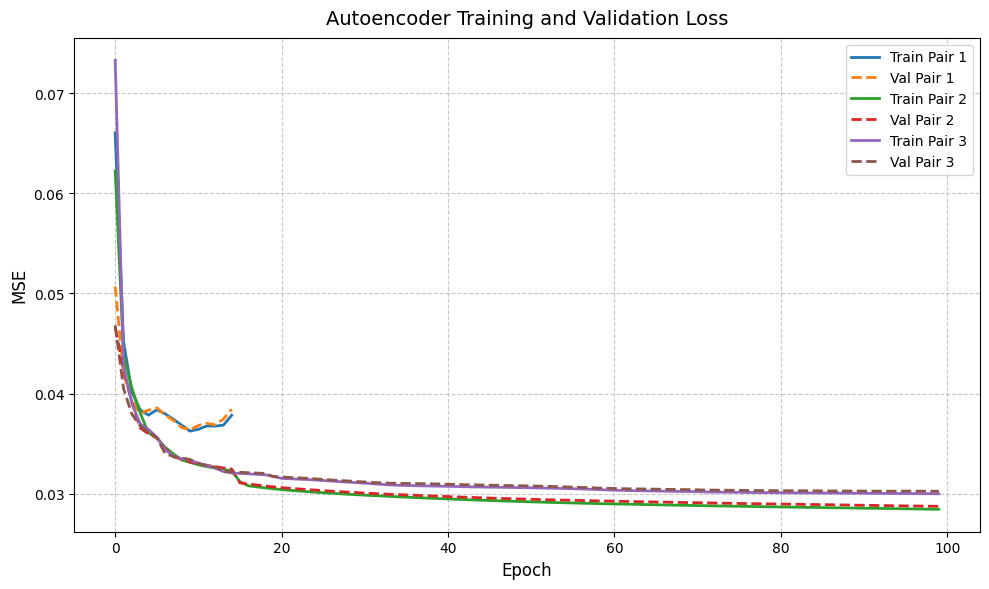

In [37]:
plt.figure(figsize=(10, 6))
for i in range(1, 4):
    plt.plot(train_mse_history[f"Pair_{i}"], label=f"Train Pair {i}", linewidth=2)
    plt.plot(val_mse_history[f"Pair_{i}"], label=f"Val Pair {i}", linestyle='--', linewidth=2)
plt.title("Autoencoder Training and Validation Loss", fontsize=14, pad=10)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.legend(fontsize=10, loc="upper right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

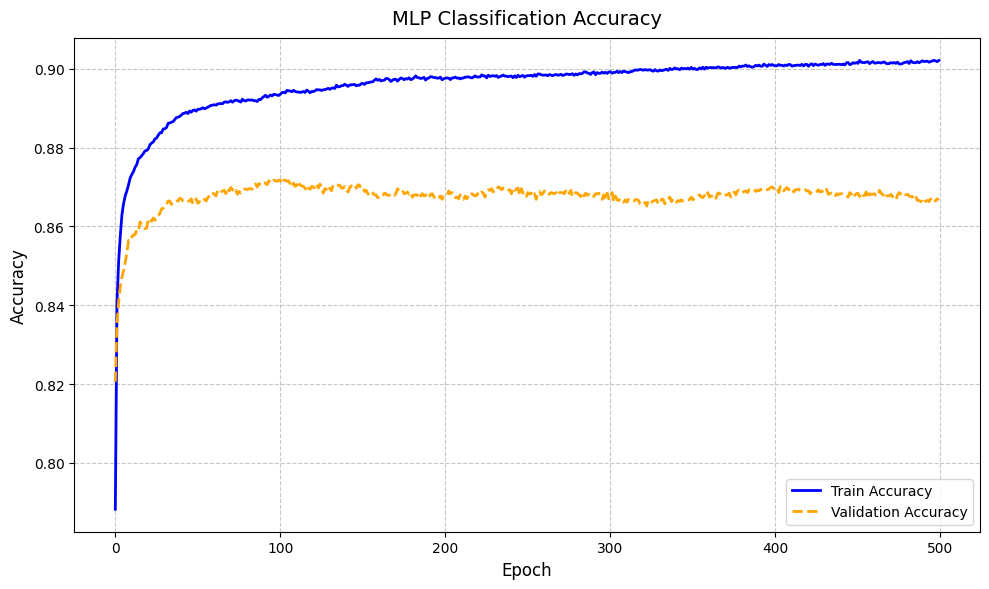

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(train_acc_history, label="Train Accuracy", linewidth=2, color='blue')
plt.plot(val_acc_history, label="Validation Accuracy", linestyle='--', linewidth=2, color='orange')
plt.title("MLP Classification Accuracy", fontsize=14, pad=10)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=10, loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

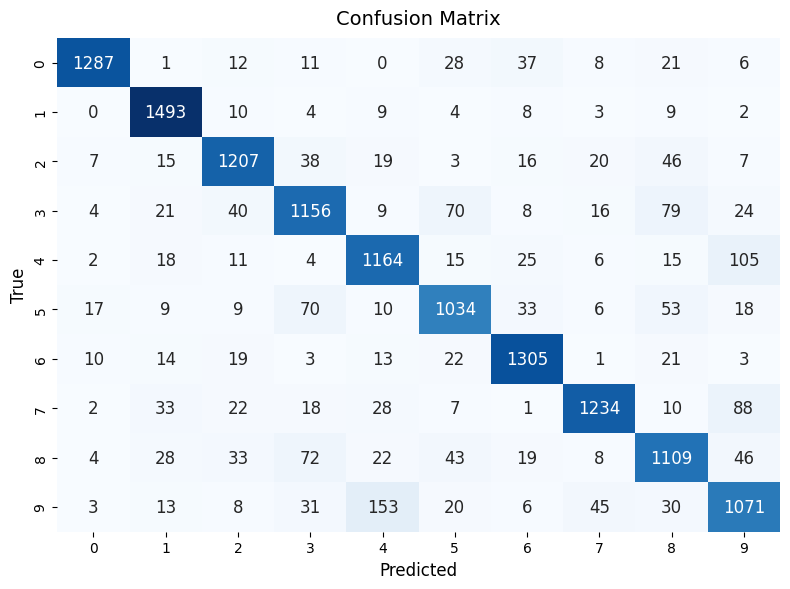

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12})
plt.title("Confusion Matrix", fontsize=14, pad=10)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.tight_layout()
plt.show()

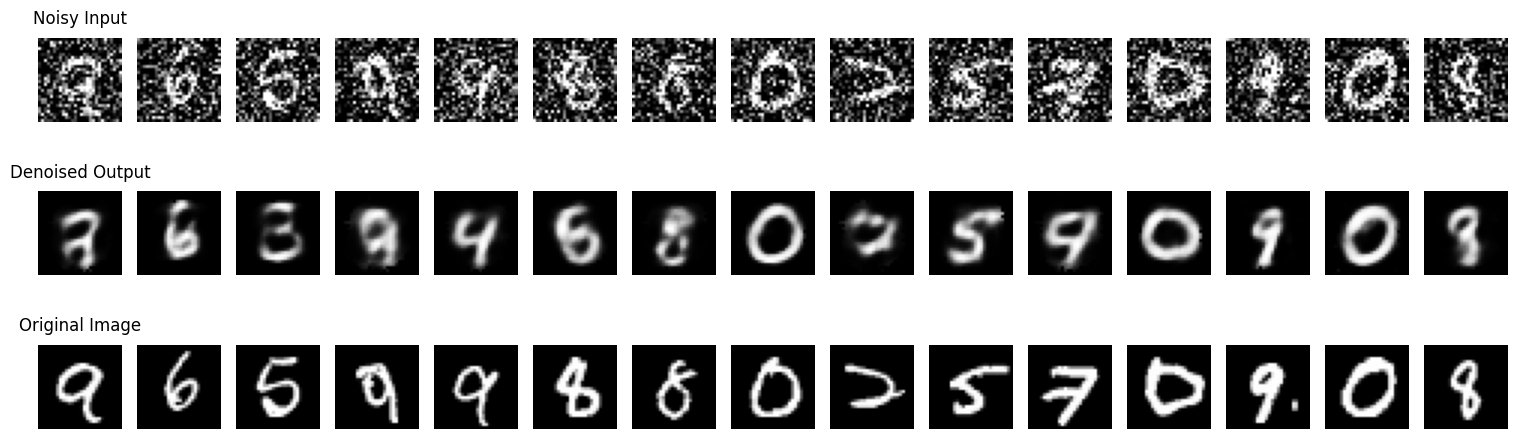

In [40]:
num_samples_to_show = 15
plt.figure(figsize=(15, 5))  # تنظیم اندازه برای نمایش 5 نمونه در یک ردیف

for i in range(num_samples_to_show):
    # Noisy Input
    plt.subplot(3, num_samples_to_show, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap="gray")
    if i == 0:
        plt.title("Noisy Input", fontsize=12, pad=10)
    plt.axis("off")
    
    # Denoised Output
    bottleneck = full_feedforward_encoder(X_test_noisy[i])  # خروجی bottleneck برای هر نمونه
    net_dec3 = np.dot(w_dec3, bottleneck) + b_dec3
    out_dec3 = get_activation(net_dec3, HP.ACT_DEC3)  # خروجی دیکودر سوم
    plt.subplot(3, num_samples_to_show, i + 1 + num_samples_to_show)
    plt.imshow(out_dec3.reshape(28, 28), cmap="gray")
    if i == 0:
        plt.title("Denoised Output", fontsize=12, pad=10)
    plt.axis("off")
    
    # Original Image
    plt.subplot(3, num_samples_to_show, i + 1 + 2 * num_samples_to_show)
    plt.imshow(X_test_clean[i].reshape(28, 28), cmap="gray")
    if i == 0:
        plt.title("Original Image", fontsize=12, pad=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Save and Load weights

In [41]:
import pickle
import os

WEIGHTS_FILE = "model_weights.pkl"

def save_weights():
    """ذخیره وزن‌ها و بایاس‌های مدل در یک فایل."""
    weights = {
        # Autoencoder weights
        "w_enc1_upper": w_enc1_upper,
        "b_enc1_upper": b_enc1_upper,
        "w_enc1_lower": w_enc1_lower,
        "b_enc1_lower": b_enc1_lower,
        "w_dec1": w_dec1,
        "b_dec1": b_dec1,
        "w_enc2": w_enc2,
        "b_enc2": b_enc2,
        "w_dec2": w_dec2,
        "b_dec2": b_dec2,
        "w_enc3": w_enc3,
        "b_enc3": b_enc3,
        "w_dec3": w_dec3,
        "b_dec3": b_dec3,
        # MLP weights
        "w_mlp1": w_mlp1,
        "b_mlp1": b_mlp1,
        "w_mlp2": w_mlp2,
        "b_mlp2": b_mlp2
    }
    with open(WEIGHTS_FILE, "wb") as f:
        pickle.dump(weights, f)
    print(f"Weights saved to {WEIGHTS_FILE}")

def load_weights():
    """بارگذاری وزن‌ها و بایاس‌ها از فایل."""
    global w_enc1_upper, b_enc1_upper, w_enc1_lower, b_enc1_lower, w_dec1, b_dec1
    global w_enc2, b_enc2, w_dec2, b_dec2, w_enc3, b_enc3, w_dec3, b_dec3
    global w_mlp1, b_mlp1, w_mlp2, b_mlp2
    
    if os.path.exists(WEIGHTS_FILE):
        with open(WEIGHTS_FILE, "rb") as f:
            weights = pickle.load(f)
        
        # Autoencoder weights
        w_enc1_upper = weights["w_enc1_upper"]
        b_enc1_upper = weights["b_enc1_upper"]
        w_enc1_lower = weights["w_enc1_lower"]
        b_enc1_lower = weights["b_enc1_lower"]
        w_dec1 = weights["w_dec1"]
        b_dec1 = weights["b_dec1"]
        w_enc2 = weights["w_enc2"]
        b_enc2 = weights["b_enc2"]
        w_dec2 = weights["w_dec2"]
        b_dec2 = weights["b_dec2"]
        w_enc3 = weights["w_enc3"]
        b_enc3 = weights["b_enc3"]
        w_dec3 = weights["w_dec3"]
        b_dec3 = weights["b_dec3"]
        # MLP weights
        w_mlp1 = weights["w_mlp1"]
        b_mlp1 = weights["b_mlp1"]
        w_mlp2 = weights["w_mlp2"]
        b_mlp2 = weights["b_mlp2"]
        
        print(f"Weights loaded from {WEIGHTS_FILE}")
    else:
        print(f"Error: {WEIGHTS_FILE} not found. Please train the model first.")

save_weights()

# load_weights()

Weights saved to model_weights.pkl
